In [1]:
import numpy as np
import matplotlib.pyplot
import mnist
import scipy
import scipy.sparse.linalg
from scipy.sparse import csr_matrix
from scipy.sparse import identity
import pdb

In [2]:
trainX, trainY = mnist.load_mnist("training", None, './MNIST');
testX, testY = mnist.load_mnist("testing", None, './MNIST');
print("MNIST loaded")

MNIST loaded


In [28]:
class logistic:
    
    
    def __init__(self, eta, lamda, thresh):
        self.eta = eta;
        self.lamda = lamda;
        self.thresh = thresh;
        self.regularized = True;
        self.lossSet = np.zeros(2000);
        self.testLossSet = np.zeros(2000);
        
    def load_train(self, trainX, trainY):
        s = trainX.shape;
        self.d = s[1] * s[2] + 1;
        self.n = self.d;
        self.N = s[0];
        self.X = np.reshape(trainX, (self.N, self.d-1));
        self.X = np.asmatrix(np.insert(self.X, 0, 1, axis=1));
        self.Y = np.zeros((self.N, 10),dtype=np.float)
        self.probTr = np.asmatrix(np.zeros((self.N, 10),dtype=float))
        
        for i in range(0,10):
            temp = np.reshape(np.array(trainY == i, dtype=float), (self.N, 1));
            self.Y[:,i] = np.asmatrix(np.reshape(temp, self.N))
        print("Training data loaded...")
        
    def load_test(self, testX, testY):
        self.testN = testX.shape[0];
        self.testX = np.reshape(testX, (self.testN, self.d-1));
        self.testX = np.insert(self.testX, 0, 1, axis=1);
        self.testY = np.zeros((self.testN, 10),dtype=np.float)
        self.probTe = np.asmatrix(np.zeros((self.testN, 10),dtype=float))
        
        for i in range(0,10):
            temp = np.reshape(np.array(testY == i, dtype=float), (self.testN, 1));
            self.testY[:,i] = np.asmatrix(np.reshape(temp, self.testN))
        print("Testing data loaded...")
    
    def initIteration(self):
        self.weights = np.asmatrix(np.zeros((self.n,10), dtype=float));
        self.iter = 0;
        self.prevLoss = 999999;
        self.weightDist = 99999;
        
        
    
    def computeProb(self):
        
        temp = self.X * self.weights;
        temp[temp>100] = 100
        
        temp = np.exp(temp);
        sumCol = np.sum(temp, axis=1)
        
        for i in range(0,10):
            self.probTr[:,i] = np.divide(temp[:,i], sumCol) 
        self.sampleLoss = self.Y - self.probTr; 
        
    def computeLoss(self):
        self.loss = -np.sum(np.log(np.sum(np.multiply(self.Y, self.probTr), axis=1) + 0.0000001)) / self.N; 
        self.lossSet[self.iter]=self.loss
    
    def computeTestLoss(self):
        temp = self.testX * self.weights;
        temp[temp>100] = 100
        
        temp = np.exp(temp);
        sumCol = np.sum(temp, axis=1)
        
        for i in range(0,10):
            self.probTe[:,i] = np.divide(temp[:,i], sumCol) 
        
        self.testLoss = -np.sum(np.log(np.sum(np.multiply(self.testY, self.probTe), axis=1) + 0.0000001)) / self.testN; 
        self.testLossSet[self.iter]=self.testLoss
    
    
    def updateWeights(self, curIdx, batchSize):
        #print('Weight ' + str(curIdx) + ' : ' + str(self.weights[curIdx]))
        self.batchSize = batchSize;
        idx_from = range(0, self.N, self.batchSize)
        idx_to = idx_from[1:]
        idx_to.extend([self.N])
        
        if self.regularized:
            for x in range(0, len(idx_from)):
                self.weights[curIdx] = self.weights[curIdx] + self.eta * np.sum(self.X[idx_from[x]:idx_to[x], curIdx] * self.sampleLoss[idx_from[x]:idx_to[x],0]);
            self.weights[curIdx] = self.weights[curIdx] - self.eta * self.weights[curIdx] * self.lamda;
            #self.weights[curIdx] = self.weights[curIdx] + self.eta * (np.sum(self.X[:, curIdx] * self.sampleLoss[:,0]) - self.weights[curIdx] * self.lamda);
        else:
            for x in range(0, len(idx_from)):
                self.weights[curIdx] = self.weights[curIdx] + self.eta * np.sum(self.X[idx_from[x]:idx_to[x], curIdx] * self.sampleLoss[idx_from[x]:idx_to[x],0]);
            #self.weights[curIdx] = self.weights[curIdx] + self.eta * np.sum(self.X[:, curIdx] * self.sampleLoss[:,0]);
        #print('Weight ' + str(curIdx) + ' : ' + str(self.weights[curIdx]))
        
    def updateWeightsWhole(self):
        deriv = self.Y - self.probTr;
        self.weights = self.weights + self.eta * self.X.transpose() * deriv / self.N
    
    def distWeight(self, A, B):
        self.weightDist = scipy.linalg.norm(A - B);
        
        print("weight distance : " + str(self.weightDist));
    
    def updateWeightStochastic(self, curIdx, curSmp):
        if self.regularized:
            self.weights[curIdx] = self.weights[curIdx] + self.eta * (self.X[curSmp, curIdx] * self.sampleLoss[curSmp,0] - self.weights[curIdx] * self.lamda);
        else:
            self.weights[curIdx] = self.weights[curIdx] + self.eta * self.X[curSmp, curIdx] * self.sampleLoss[curSmp,0];
    
    def assess(self):
        model.predLabel = np.argmax(model.probTr, axis=1);
        temp = (model.predLabel != np.reshape(trainY, (model.N, 1))).astype(float)
        model.loss01 = np.sum(temp) / model.N;
        print("0 / 1 loss : " + str(model.loss01));
        
        self.predLabel = np.argmax(self.probTr, axis=1);
        self.pred = self.probTr > 0.5;
        self.correct = np.sum(np.int16(self.pred == (self.Y==1)))
        self.overallAccu = np.float(self.correct) / np.float(self.N);
        self.loss01 = sum(abs(self.pred - self.Y)) / self.N
        print('Accuracy : ' + str(self.overallAccu))
        print('0 / 1 loss : ' + str(self.loss01))
    
    def genGaussFeatWeight(self, n):
        self.n = n;
        self.weight = np.random.randn(self.d, self.n);
    
    def randGaussFeatConv(self):
        self.X = np.dot(self.X, self.weight);
        
    def plotLoss(self, labelTrain, labelTest, name):
        %matplotlib inline 
        matplotlib.pyplot.plot(np.arange(0, model.iter), model.testLossSet[0:model.iter], hold = True, color="blue", linewidth=2.0)
        matplotlib.pyplot.plot(np.arange(0, model.iter), model.lossSet[0:model.iter], hold = True, color="red", linewidth=2.0)
        matplotlib.pyplot.savefig(name, transparent = True)
        

In [29]:
model = logistic(0.1, 0.01, 0.001);
model.load_train(trainX, trainY);
model.load_test(testX, testY);

Training data loaded...
Testing data loaded...


Iteration 0 : Loss value 2.30258409299
weight distance : 0.104093194111
Iteration 1 : Loss value 2.19694200854
weight distance : 0.0991989038061
Iteration 2 : Loss value 2.10055075046
weight distance : 0.0952525924058
Iteration 3 : Loss value 2.01154110478
weight distance : 0.0916775576616
Iteration 4 : Loss value 1.9290567765
weight distance : 0.0882795415428
Iteration 5 : Loss value 1.85257342268
weight distance : 0.0850006145579
Iteration 6 : Loss value 1.78167130132
weight distance : 0.0818299518774
Iteration 7 : Loss value 1.71596298254
weight distance : 0.0787711075162
Iteration 8 : Loss value 1.65507427545
weight distance : 0.0758303883867
Iteration 9 : Loss value 1.59864229782
weight distance : 0.0730130358433
Iteration 10 : Loss value 1.5463181352
weight distance : 0.0703222114679
Iteration 11 : Loss value 1.49776996434
weight distance : 0.0677589466586
Iteration 12 : Loss value 1.45268545187
weight distance : 0.0653224016461
Iteration 13 : Loss value 1.41077321333
weight dist

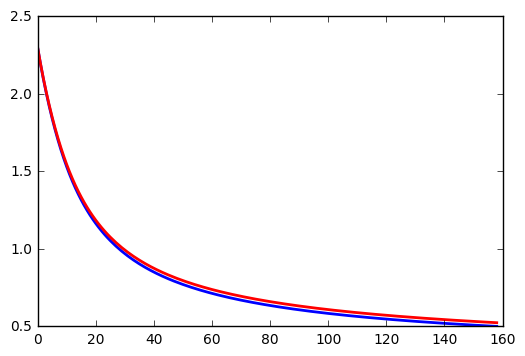

In [30]:
model.initIteration();
model.computeProb();
model.computeLoss();
model.computeTestLoss()
print ('Iteration 0 : Loss value ' + str(model.loss))

#while (model.weightDist > 0.01 or model.iter<3):
while (model.prevLoss - model.loss > model.thresh or model.iter<10):
    model.prevLoss = model.loss;
    model.iter = model.iter + 1;
    temp = model.weights.copy();
    
    model.updateWeightsWhole()
    model.computeProb();
    
        
    model.computeLoss()
    model.computeTestLoss()
    model.distWeight(temp, model.weights)
    print ('Iteration ' + str(model.iter) + ' : Loss value ' + str(model.loss))
model.plotLoss('training loss', 'testing loss', 'softloss.png')

In [59]:
model.predLabel = np.argmax(model.probTr, axis=1);
temp = (model.predLabel != np.reshape(trainY, (model.N, 1))).astype(float)
model.loss01 = np.sum(temp) / model.N;
print("0 / 1 loss : " + str(model.loss01));
print("Training log loss : " + str(model.loss))
        
model.predLabel = np.argmax(model.probTe, axis=1);
temp = (model.predLabel != np.reshape(testY, (model.testN, 1))).astype(float)
model.loss01 = np.sum(temp) / model.testN;
print("0 / 1 loss : " + str(model.loss01));
print("Testing log loss : " + str(model.testLoss))

0 / 1 loss : 0.128116666667
Training log loss : 0.523115376005
0 / 1 loss : 0.1191
Testing log loss : 0.499376937195
